# Consumer Reviews Summarization - Project Part 3


[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/Ariamestra/ConsumerReviews/blob/main/project_part3.ipynb)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Ariamestra/ConsumerReviews/blob/main/project_part3.ipynb)


## 1. Introduction
My goal for this project is to develop a system capable of generating concise summaries of customer reviews. This will help users in quickly skim through feedback on products by transforming detailed reviews into short comments. These comments will be categorized as positive, neutral, or negative, corresponding to the sentiment of the rating provided. To achieve this, the system will use the capabilities of the pre-trained T5 model. I selected the T5 model as my pre-trained choice because it is a text-to-text transformer, thats good at tasks like summarization. I opted for [T5-small](https://huggingface.co/t5-small) due to its size, which is more manageable. Additionally, T5 is versatile in handling different summarization types, like extractive summarization where it picks out important sentences from the text.<br>
<br>

**Data** <br>
The dataset was sourced from Kaggle, specifically the [Consumer Review of Clothing Product](https://www.kaggle.com/datasets/jocelyndumlao/consumer-review-of-clothing-product)
 dataset. This dataset includes customer reviews from Amazon. It has all sorts of feedback from buyers about different products. Along with the customers' actual reviews, ratings, product type, material, construction, color, finish, and durability.<br>



In [10]:
# Import all packages needed
#!pip install transformers pandas nltk scikit-learn
#!pip install sentencepiece
#!pip install transformers[torch]
#!pip install hyperopt

#! pip install --upgrade transformers huggingface_hub
#!pip install --upgrade transformers
#!pip uninstall transformers huggingface_hub
#!pip install transformers huggingface_hub

import pandas as pd
import re
import nltk
import torch
import sys
import sentencepiece as spm
import string
import matplotlib.pyplot as plt
import numpy as np

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import T5ForConditionalGeneration, T5Tokenizer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from transformers import pipeline
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from scipy.stats import uniform

#nltk.download('punkt')       
#nltk.download('stopwords')  
#nltk.download('wordnet') 

pipe = pipeline("translation", model="t5-small")

tokenizer = AutoTokenizer.from_pretrained("t5-small")
model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")
  
data_URL = 'https://raw.githubusercontent.com/Ariamestra/ConsumerReviews/main/Reviews.csv'
df = pd.read_csv(data_URL)
print(f"Shape: {df.shape}")
df.head()

/home/codespace/.python/current/lib/python3.10/site-packages/transformers/pipelines/__init__.py:1049: UserWarning: "translation" task was used, instead of "translation_XX_to_YY", defaulting to "translation_en_to_de"
  warnings.warn(


Shape: (49338, 9)


,Title,Review,Cons_rating,Cloth_class,Materials,Construction,Color,Finishing,Durability
0,NaN,Absolutely wonderful - silky and sexy and comf...,4.0,Intimates,0.0,0.0,0.0,1.0,0.0
1,NaN,Love this dress! it's sooo pretty. i happene...,5.0,Dresses,0.0,1.0,0.0,0.0,0.0
2,Some major design flaws,I had such high hopes for this dress and reall...,3.0,Dresses,0.0,0.0,0.0,1.0,0.0
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5.0,Pants,0.0,0.0,0.0,0.0,0.0
4,Flattering shirt,This shirt is very flattering to all due to th...,5.0,Blouses,0.0,1.0,0.0,0.0,0.0


Drop all of the nulls in the data

In [11]:
# Count nulls in reviews
number_of_nulls = df['Review'].isnull().sum()
print(f"Number of nulls in the reviews: {number_of_nulls}")

# Count nulls in ratings
number_of_nulls_in_ratings = df['Cons_rating'].isnull().sum()
print(f"Number of nulls in the ratings: {number_of_nulls_in_ratings}")

original_count = df.shape[0]
df_cleaned = df.dropna(subset=['Review', 'Cons_rating']) # Drop rows with nulls in reviews and ratings columns
cleaned_count = df_cleaned.shape[0] # Number of rows after dropping nulls
rows_dropped = original_count - cleaned_count

print(f"Number of rows dropped: {rows_dropped}")

df_shape_after_dropping = df_cleaned.shape

print(f"Shape of the DataFrame after dropping rows: {df_shape_after_dropping}")

Number of nulls in the reviews: 831
Number of nulls in the ratings: 214
Number of rows dropped: 1043
Shape of the DataFrame after dropping rows: (48295, 9)


Get review length

In [12]:
# Review length of reviews
df_cleaned = df_cleaned.copy()
df_cleaned['Review_length'] = df_cleaned['Review'].apply(lambda x: len(str(x).split()))

# Filter out reviews that are shorter than 30 words 
df_cleaned.drop(df_cleaned[df_cleaned['Review_length'] < 30].index, inplace=True)

# Longest and shortest reviews in df_cleaned
longest_review_row = df_cleaned.loc[df_cleaned['Review_length'].idxmax()]
longest_review = longest_review_row['Review']
longest_review_length = longest_review_row['Review_length']

shortest_review_row = df_cleaned.loc[df_cleaned['Review_length'].idxmin()]
shortest_review = shortest_review_row['Review']
shortest_review_length = shortest_review_row['Review_length']

print(f"Longest review length: {longest_review_length} words")
print(f"Shortest review length: {shortest_review_length} words")
print(f"Shape of the DataFrame after dropping rows below 20 words: {df_cleaned.shape}")

Longest review length: 668 words
Shortest review length: 30 words
Shape of the DataFrame after dropping rows below 20 words: (26680, 10)


Clean reviews

In [13]:
# Drop columns that are not needed
columns_to_drop = ['Cloth_class', 'Title', 'Materials', 'Construction', 'Color', 'Finishing', 'Durability']
columns_to_drop = [col for col in columns_to_drop if col in df_cleaned.columns]
df_cleaned.drop(columns=columns_to_drop, inplace=True)

stop_words = set(stopwords.words('english'))

def clean_review(review):
    review = str(review).lower()
    review = review.translate(str.maketrans('', '', string.punctuation))
    words = word_tokenize(review)
    words = [word for word in words if word.isalpha() and word not in stop_words]
    return ' '.join(words)

# Apply the cleaning
df_cleaned['Processed_Review'] = df_cleaned['Review'].apply(clean_review)

# Calculate the review lengths 
df_cleaned['Review_length'] = df_cleaned['Processed_Review'].apply(lambda x: len(x.split()))

print("Shape after dropping rows:", df_cleaned.shape)
print(df_cleaned.head())


Shape after dropping rows: (26680, 4)
                                              Review  Cons_rating  \
1  Love this dress!  it's sooo pretty.  i happene...          5.0   
2  I had such high hopes for this dress and reall...          3.0   
4  This shirt is very flattering to all due to th...          5.0   
5  I love tracy reese dresses, but this one is no...          2.0   
6  I aded this in my basket at hte last mintue to...          5.0   

   Review_length                                   Processed_Review  
1             30  love dress sooo pretty happened find store im ...  
2             48  high hopes dress really wanted work initially ...  
4             16  shirt flattering due adjustable front tie perf...  
5             39  love tracy reese dresses one petite feet tall ...  
6             48  aded basket hte last mintue see would look lik...  


Split the dataset into train and test Sets after TF-IDF vectorization

In [14]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df_cleaned['Processed_Review'], df_cleaned['Cons_rating'], test_size=0.2, random_state=42)

# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', max_df=0.95, min_df=0.05)

# Fit to the training data 
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Calculate the total number 
X = df_cleaned['Processed_Review']
total_samples = X.shape[0]
train_size = X_train.shape[0]
test_size = X_test.shape[0]

train_percentage = (train_size / total_samples) * 100
test_percentage = (test_size / total_samples) * 100

print(f"Total dataset size: {total_samples}")
print(f"Train size: {train_size} ({train_percentage:.2f}%)")
print(f"Test size: {test_size} ({test_percentage:.2f}%)")

Total dataset size: 26680
Train size: 21344 (80.00%)
Test size: 5336 (20.00%)


Model training, model tuning and model evaluation using different methods

1st Model - Logistic Regression Model

This first model uses logistic regression model to enhance feature selection and reduce overfitting. To enhance this model's performance, two regularization techniques are used: L1 and L2 regularization. L1 regularization, also known as Lasso Regression simplifies machine learning models by removing less important features and reducing overfitting, especially when there are many features. L2 regularization, also known as Ridge Regression, reduces overfitting in machine learning models by shrinking feature coefficients without removing them, making the model more stable, especially when features are closely related. Together, L1 and L2 regularization techniques provide a balanced approach to refining the logistic regression model. 

Reference: [Regularization — Understanding L1 and L2 regularization for Deep Learning](https://medium.com/analytics-vidhya/regularization-understanding-l1-and-l2-regularization-for-deep-learning-a7b9e4a409bf)


/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--------------------------------------------------------------------------------
Best Accuracy: 0.558095952023988, Best C for Accuracy: 1.623776739188721
Best Log Loss: 1.104818548274103, Best C for Log Loss: 10000.0
--------------------------------------------------------------------------------


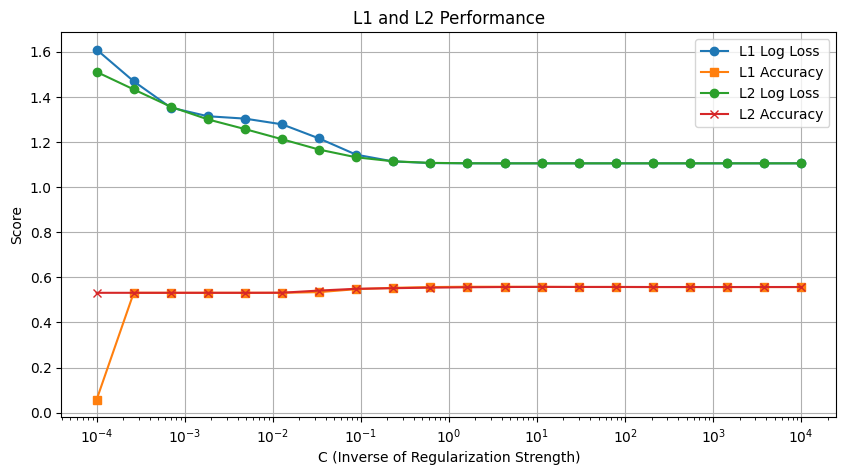

In [15]:

# ------------------------------- Model Traning -------------------------------
# Define the model
lr_model = LogisticRegression(random_state=42)

# Fit the model
lr_model.fit(X_train_tfidf, y_train_encoded)

# Predict probabilities
y_pred_proba = lr_model.predict_proba(X_test_tfidf)

# Calculate log loss
loss = log_loss(y_test_encoded, y_pred_proba)

# ------------------------------- Model Tuning -------------------------------
# Define parameters
param_grid = {
    'C': np.logspace(-4, 4, 20),  # values between 10^-4 and 10^4
    'penalty': ['l1', 'l2'],  # l1 and l2 
    'solver': ['liblinear']  # liblinear works well with l1 and l2
}

# Initialize Grid Search
grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, scoring='neg_log_loss')
grid_search.fit(X_train_tfidf, y_train_encoded)

# Get the best parameters and log loss
best_params = grid_search.best_params_
best_log_loss = -grid_search.best_score_

# Fit GridSearchCV
grid_search.fit(X_train_tfidf, y_train_encoded)

# CV results
cv_results = grid_search.cv_results_

# Create DataFrame from CV results
results_df = pd.DataFrame(cv_results)

# ------------------------------- Model Evaluation -------------------------------

test_accuracies = []
log_losses = []
for i in range(results_df.shape[0]):
    # Get model
    model = grid_search.best_estimator_.set_params(**results_df.loc[i, 'params'])

    # Fit and predict
    model.fit(X_train_tfidf, y_train_encoded)
    y_pred = model.predict(X_test_tfidf)
    y_pred_proba = model.predict_proba(X_test_tfidf)

    # Calculate accuracy and log loss
    test_accuracies.append(accuracy_score(y_test_encoded, y_pred))
    log_losses.append(log_loss(y_test_encoded, y_pred_proba))

results_df['test_accuracy'] = test_accuracies
results_df['test_log_loss'] = log_losses

# Find the best accuracy and log loss
best_accuracy_index = np.argmax(results_df['test_accuracy'])
best_accuracy = results_df['test_accuracy'][best_accuracy_index]
best_C_for_accuracy = results_df['param_C'][best_accuracy_index]

# Find the best log loss and C value
best_log_loss_index = np.argmin(results_df['test_log_loss'])
best_log_loss = results_df['test_log_loss'][best_log_loss_index]
best_C_for_log_loss = results_df['param_C'][best_log_loss_index]

print('-' * 80)
print(f"Best Accuracy: {best_accuracy}, Best C for Accuracy: {best_C_for_accuracy}")
print(f"Best Log Loss: {best_log_loss}, Best C for Log Loss: {best_C_for_log_loss}")
print('-' * 80)

# Separate data 
l1_data = results_df[results_df['param_penalty'] == 'l1']
l2_data = results_df[results_df['param_penalty'] == 'l2']

# Print graph
plt.figure(figsize=(10, 5))

# L1
l1_data = results_df[results_df['param_penalty'] == 'l1']
plt.plot(l1_data['param_C'], -l1_data['mean_test_score'], label='L1 Log Loss', marker='o')
plt.plot(l1_data['param_C'], l1_data['test_accuracy'], label='L1 Accuracy', marker='s')

# L2
l2_data = results_df[results_df['param_penalty'] == 'l2']
plt.plot(l2_data['param_C'], -l2_data['mean_test_score'], label='L2 Log Loss', marker='o')
plt.plot(l2_data['param_C'], l2_data['test_accuracy'], label='L2 Accuracy', marker='x')

plt.xscale('log')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Score')
plt.title('L1 and L2 Performance')
plt.legend()
plt.grid(True)

plt.show()


2nd Model - Bayesian Optimization

This second model uses Bayesian Optimization for tuning a logistic regression model, a method more efficient than traditional grid search. It searches for the best hyperparameters, it searches through the hyperparameters to find the best ones. After finding these optimal settings, a new logistic regression model is trained and its accuracy is tested. 

Reference: [Bayesian Optimization Concept Explained in Layman Terms](https://towardsdatascience.com/bayesian-optimization-concept-explained-in-layman-terms-1d2bcdeaf12f)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 100/100 [00:39<00:00,  2.50trial/s, best loss: -0.5586581709145427]
--------------------------------------------------------------------------------
Best Accuracy from best model: 0.5584707646176912
Best Parameters: {'C': 4.748644429837617, 'penalty': 0}
--------------------------------------------------------------------------------


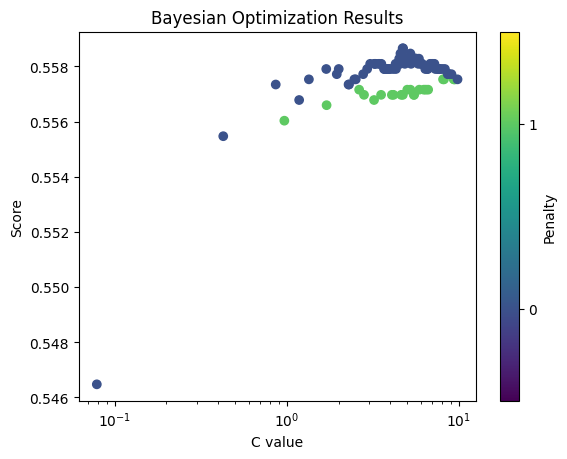

In [16]:
# ------------------------------- Model Tuning -------------------------------
space = {
    'C': hp.uniform('C', 0.01, 10.0),
    'penalty': hp.choice('penalty', ['l1', 'l2'])
}

def objective(params):
    model = LogisticRegression(**params, solver='liblinear')
    model.fit(X_train_tfidf, y_train)
    score = model.score(X_test_tfidf, y_test)
    return {'loss': -score, 'status': STATUS_OK}

# Run algorithm
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

# ------------------------------- Model Evaluation -------------------------------

penalty_choice = ['l1', 'l2'][best['penalty']]
best_model = LogisticRegression(
    C=best['C'],
    penalty=penalty_choice,
    solver='liblinear'
)
best_model.fit(X_train_tfidf, y_train)

# Calculate accuracy
best_accuracy = best_model.score(X_test_tfidf, y_test)
print('-' * 80)
print(f"Best Accuracy from best model: {best_accuracy}")
print(f"Best Parameters: {best}")
print('-' * 80)


C_values = [x['misc']['vals']['C'][0] for x in trials.trials]
penalties = [x['misc']['vals']['penalty'][0] for x in trials.trials]
losses = [-x['result']['loss'] for x in trials.trials]

penalties = ['l1' if p == 0 else 'l2' for p in penalties]

plt.scatter(C_values, losses, c=[penalties.index(p) for p in penalties], cmap='viridis')
plt.colorbar(ticks=[0, 1], label='Penalty')
plt.clim(-0.5, 1.5)
plt.xlabel('C value')
plt.ylabel('Score')
plt.xscale('log')
plt.title('Bayesian Optimization Results')
plt.show()


3rd Model - Randomized Search

This third model uses  Randomized Search to fine-tune a logistic regression model. This method randomly selects combinations of hyperparameters and tests them to find the best one. The process is repeated 100 times, and each time, the model is evaluated using 5-fold cross-validation, which helps in assessing the model's performance accurately. 

Reference: [Hyperparameter Optimization With Random Search and Grid Search](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/)

--------------------------------------------------------------------------------
Best Parameters: {'C': 0.923575302488596, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.5541601107173333
--------------------------------------------------------------------------------


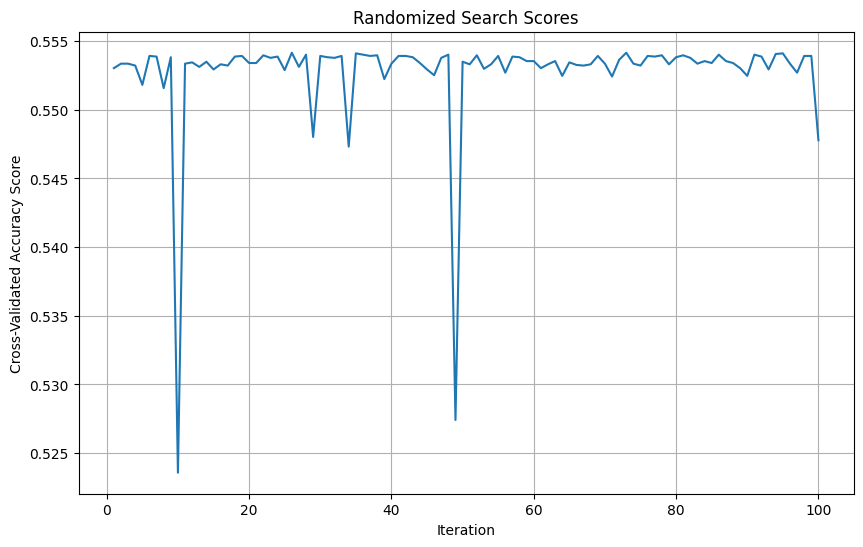

In [17]:
# ------------------------------- Model Evaluation -------------------------------

param_dist = {
    'C': uniform(loc=0, scale=4),  # Range [0,4]
    'penalty': ['l2', 'l1'],
    'solver': ['liblinear']
}

# ------------------------------- Model Tuning -------------------------------

random_search = RandomizedSearchCV(estimator=lr_model, param_distributions=param_dist, n_iter=100, cv=5, random_state=42)
random_search.fit(X_train_tfidf, y_train)

# Get best 
best_params_random = random_search.best_params_
best_score_random = random_search.best_score_

print('-' * 80)
print(f"Best Parameters: {best_params_random}")
print(f"Best Score: {best_score_random}") # accuracy
print('-' * 80)

scores = random_search.cv_results_['mean_test_score']

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(scores) + 1), scores)
plt.title('Randomized Search Scores')
plt.xlabel('Iteration')
plt.ylabel('Cross-Validated Accuracy Score')
plt.grid(True)
plt.show()


Summarization

The best accuracy was achieved with bayesian optimization model (0.5584707646176912). This means the model will be trained with this level of accuracy.

In [18]:
best_params = {'C': 4.740073122411433, 'penalty': 'none'}
lr_model = LogisticRegression(C=best_params['C'], penalty=best_params['penalty'])
lr_model.fit(X_train_tfidf, y_train)

best_score = lr_model.score(X_test_tfidf, y_test) 
print('-' * 80)

# Sentiment
def classify_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

# ----- needs for no errors
t5_model = T5ForConditionalGeneration.from_pretrained('t5-small')
t5_tokenizer = T5Tokenizer.from_pretrained('t5-small')

def summarize_text(text, best_score):
    inputs = t5_tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=668, truncation=True)
    # Generate summary 
    outputs = t5_model.generate(inputs, max_length=668, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True) # needs length penalty, num beams and early stopping for better summarization.
    summary = t5_tokenizer.decode(outputs[0], skip_special_tokens=True)
    # best_score and summary
    summary_with_score = f"{summary}\nModel's Best Score: {best_score:.2f}"
    return summary_with_score

# Applying sentiment 
df_cleaned['Sentiment'] = df_cleaned['Cons_rating'].apply(classify_sentiment)

for index, row in df_cleaned.head(15).iterrows():
    original_review = row['Review']
    sentiment = classify_sentiment(row['Cons_rating'])
    summarized_review = summarize_text(original_review, best_score)  # Pass best_score here
    original_word_count = len(original_review.split())
    summarized_word_count = len(summarized_review.split())

    print(f"Original Review: {original_review}")
    print(f"Sentiment: {sentiment}")
    print(f"Original Review Word Count: {original_word_count}\n")
    print(f"Summarized Review: {summarized_review}")
    print(f"Summarized Review Word Count: {summarized_word_count}")
    print("\n" + "-"*80 + "\n")


/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--------------------------------------------------------------------------------


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Original Review: Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite.  i bought a petite and am 5'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.
Sentiment: positive
Original Review Word Count: 62

Summarized Review: i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8" and i love the length on me.
Model's Best Score: 0.56
Summarized Review Word Count: 33

--------------------------------------------------------------------------------

Original Review: I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely,

## Conclusion
In conclusion, the project has successfully used the pre-trained T5 model to transform extensive customer reviews into brief summaries. This advancement not only enhances the efficiency of user evaluations by providing understanding into product feedback. The implementation of this summarization tool shows practical use of text-to-text transformers in real-world scenarios, simplifying the decision-making process for consumers.